In [1]:
# MESH is toolkit for facets and meshes
# FEM is function toolkit
# IO is file manager
# PLOT is plot manager
# MPI for multyprocessors operation
# UFL is folrmula translator
# PETS is linear algebra solver

from dolfinx import mesh, fem, io, plot
import ufl
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt


class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def data_construct(geometry, x_array):
    data = np.column_stack((geometry[:, 0:2], x_array))
    x_data = data[:, 0]
    y_data = data[:, 1]
    z_data = data[:, 2]
    return [x_data, y_data, z_data]

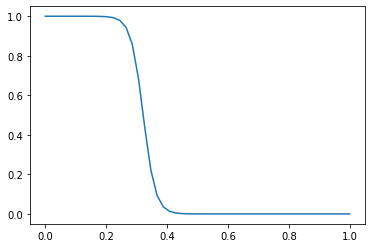

In [94]:
def sigmoid(x):
    return 1 / (1 + 50 * np.exp(50*x - 20))


test1 = np.linspace(0, 1)
plt.plot(test1, sigmoid(test1))

In [95]:
N = 200
# def_uD = lambda x: 1 - x[0]**2 - 2 * x[1]**2
# def_uD = lambda x: np.where(x[0] < 0.5, 1 - x[0]**2 - 2 * x[1]**2, 0)
def_uD = lambda x: (1 - x[0]**2 - 2 * x[1]**2) * sigmoid(x[0])
defc_f = -6
defc_alpha = 10E+10

# Solver

In [96]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = fem.FunctionSpace(domain, ('Lagrange', 1))
dot = Infix(ufl.inner)
grad = ufl.grad
dx = ufl.dx
ds = ufl.ds

In [98]:
# Set boundary conditions in equation right now
uD = fem.Function(V)
uD.interpolate(def_uD)

u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType(defc_f))
n = ufl.FacetNormal(domain)
alpha = fem.Constant(domain, ScalarType(defc_alpha))
h = 2 * ufl.Circumradius(domain)

F = (grad(u)|dot|grad(v)) * dx -(grad(u)|dot|n) * v * ds -\
    (grad(v)|dot|n) * u * ds + alpha/h*u*v*ds +\
    f*v*dx +\
    (grad(v)|dot|n) * uD * ds - alpha/h*uD*v*ds

In [99]:
problem = fem.petsc.LinearProblem(ufl.lhs(F), ufl.rhs(F))
uS = problem.solve()

In [100]:
# L2 error
V_err = fem.FunctionSpace(domain, ('CG', 2))
u_err = fem.Function(V_err)
u_err.interpolate(def_uD)
L2 = fem.form(((uS - u_err)|dot|(uS - u_err)) * dx)

err_local = fem.assemble_scalar(L2)
err_L2 = np.sqrt(domain.comm.allreduce(err_local, op=MPI.SUM))
err_L1 = np.max(np.abs(uS.x.array - uD.x.array))

# Graph

In [101]:
print(f' Local error = {err_local:.2e} \n L2 norm = {err_L2:.2e} \n L1 norm = {err_L1:.2e}')

 Local error = 7.46e-02 
 L2 norm = 2.73e-01 
 L1 norm = 6.16e-01


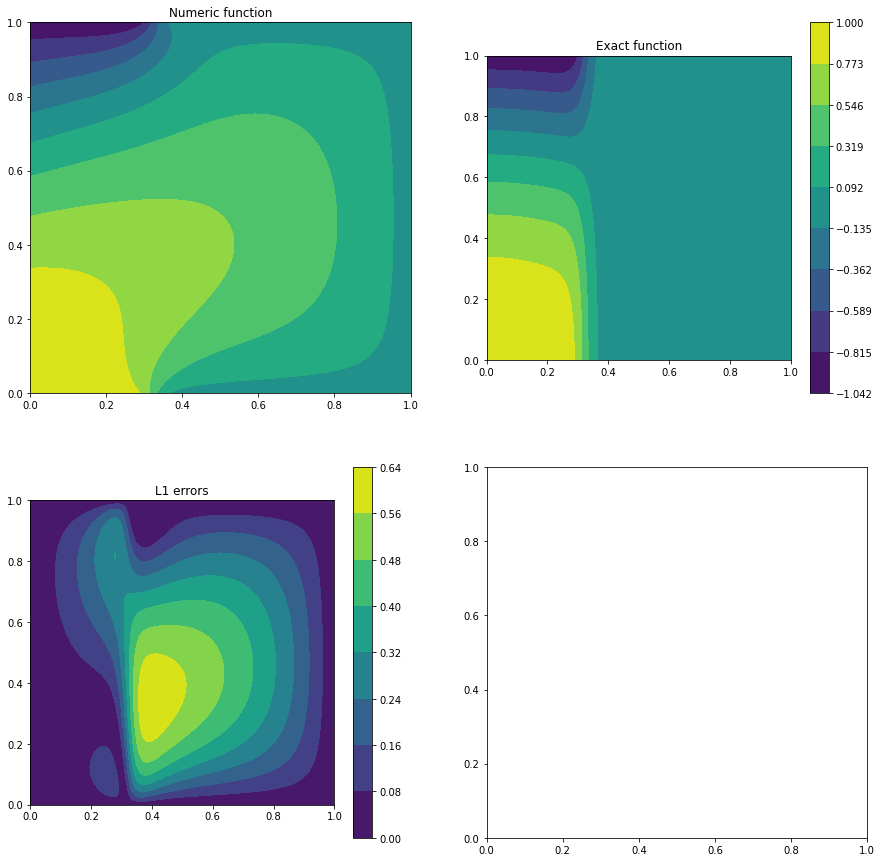

In [102]:
geometry = domain.geometry.x
levels = np.linspace(uS.x.array.min(), uS.x.array.max(), 10)

fig, ((ax_sol, ax_d), (ax_er, ax_1)) = plt.subplots(2, 2)
fig.set_size_inches(15, 15)

ax_sol.set_title('Numeric function')
ax_sol.tricontourf(*data_construct(geometry, uS.x.array), levels=levels)

ax_d.set_title('Exact function')
ax0 = ax_d.tricontourf(*data_construct(geometry, uD.x.array), levels=levels)
fig.colorbar(ax0, ax=ax_d)
ax_d.set_aspect(1)

ax_er.set_title('L1 errors')
a1 = ax_er.tricontourf(
    *data_construct(geometry, np.abs(uS.x.array - uD.x.array))
    )
ax_er.set_aspect(1)
fig.colorbar(a1, ax=ax_er)